# Install libraries

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 13.7 MB/s 


In [ ]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

# Confirm mtcnn was installed correctly
import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIRECTORY = "/content/drive/My Drive/yale/"

# EDA
After importing the datset i first began by visualising the first three subjcts with two different poses (centerlight and sad), to better understand the images within.


**Subject01**

(243, 320, 3)


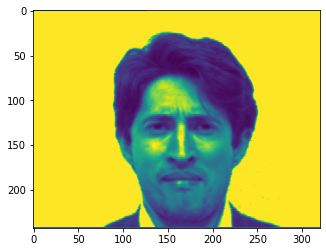

In [ ]:
filename = "/content/drive/My Drive/yale/subject03.sad"
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)
plt.imshow(pixels)
plt.show()

# Data Processing

In [ ]:
# Create the detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(rgb_pixels)

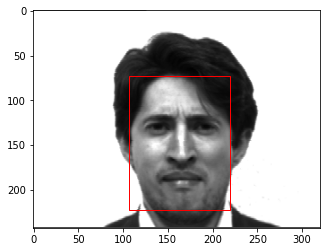

In [ ]:
# draw an image with detected objects
def draw_image_with_boxes(data, result_list):
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()

# display faces on the original image
draw_image_with_boxes(rgb_pixels, results)

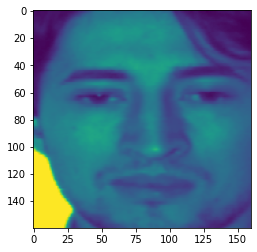

In [ ]:
# extract a single face from a given photograph
def extract_face_from_file(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    
    return extract_face(image, required_size)

def extract_face(image, required_size=(160, 160)):
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    
    return gray_face


# Create the detector, using default weights
detector = MTCNN()

# load the photo and extract the face
face_pixels = extract_face_from_file("/content/drive/My Drive/yale/subject03.centerlight")

plt.imshow(face_pixels)

**For later use within algorithms we will create a dataframe of the datset**

In [ ]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)
# list filenames
filenames = pd.DataFrame(list_files(DIRECTORY, "subject"))

# generate split 
df = filenames[0].str.split(".", expand=True)
df["filename"] = filenames

# # tidy columns
df = df.rename(columns = {0:"subject", 1:"category"})
df['subject'] = df.subject.str.replace('subject' , '')
df.apply(pd.to_numeric, errors='coerce').dropna()
df['subject'] = pd.to_numeric(df["subject"])
df

,subject,category,filename
0,1,rightlight,subject01.rightlight
1,3,happy,subject03.happy
2,11,leftlight,subject11.leftlight
3,8,surprised,subject08.surprised
4,15,sleepy,subject15.sleepy
...,...,...,...
160,4,normal,subject04.normal
161,8,glasses,subject08.glasses
162,14,sad,subject14.sad
163,8,sleepy,subject08.sleepy


**Split the data into training and testing sets**

In [ ]:
y = df['subject']
X = df.drop('subject',axis=1)

# # subject
X_train_info, X_test_info, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=45, stratify=y)

y_train = y_train.tolist()
y_test = y_test.tolist()

In [ ]:
detector = MTCNN()

def load_dataset(dataset):
    faces = list()
    for filename in tqdm(dataset["filename"]):
        path = DIRECTORY + filename
        # get face
        face = extract_face_from_file(path)
        faces.append(face)
    return np.asarray(faces)

In [ ]:
X_test = load_dataset(X_test_info)
X_train = load_dataset(X_train_info)

print(X_test.shape)
print(X_train.shape)

100%|██████████| 132/132 [00:57<00:00,  2.31it/s]

(33, 160, 160)
(132, 160, 160)


In [ ]:
# create a facial classification system
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import random
# Normalize vector inputs
in_encoder = Normalizer(norm='l2')

X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
print('Reshaped X_train', X_train_reshaped.shape)
X_train_reshaped = in_encoder.transform(X_train_reshaped)

X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
print('Reshaped X_test', X_test_reshaped.shape)
X_test_reshaped = in_encoder.transform(X_test_reshaped)

# Encode targets with labels
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

# Fit model
model = SVC(kernel='linear', probability=True)
model.fit(X_train_reshaped, y_train)

# Predict
yhat_train = model.predict(X_train_reshaped)
yhat_test = model.predict(X_test_reshaped)

Reshaped X_train (132, 25600)
Reshaped X_test (33, 25600)


In [ ]:
# Score
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)
# Summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=80.303, test=72.727


Text(0.5, 33.0, 'X')

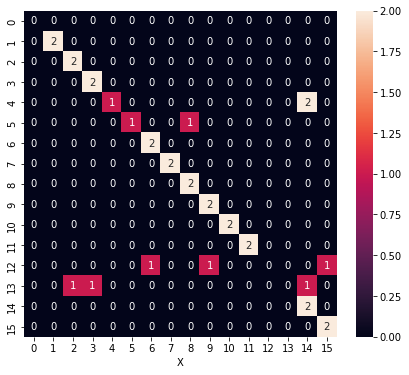

In [ ]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
import tensorflow as tf

cm = tf.math.confusion_matrix(labels=y_test, predictions=yhat_test)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('X')

# CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, constraints
from tensorflow.keras import models

**Initialize parameters**

In [ ]:
#initilize parameters
width, height = 160, 160
num_epochs = 25
batch_size = 20
num_features = 64

In [ ]:
import keras
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

**Define model**

In [ ]:
# Define a sequential keras model
cnnmodel = models.Sequential()

# 1st Convolution layer
cnnmodel.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(width, height, 1), padding='same'))
cnnmodel.add(MaxPooling2D((2, 2)))

# 2nd Convolution layer
cnnmodel.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolution layer
cnnmodel.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the Convolution
cnnmodel.add(Flatten())

# Define a dense layer with l2 regularizer to reduce overfitting
cnnmodel.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

# Define a drop layer to reduce overfitting
cnnmodel.add(MCDropout(rate=0.5))

# Final output layer
cnnmodel.add(Dense(15, activation='softmax', kernel_initializer="glorot_uniform"))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras import models

**Save test/train datsets**

In [ ]:
import os 

def save_keras_dataset(setname, dataset, labels, per_class):
    # combine labels and images to generate files
    data = sorted(list(zip(labels, dataset)), key=lambda x: x[0])

    # Save images
    j = 0
    for label, gray_img in tqdm(data):
        j = (j% per_class) + 1
        # Create directory
        directory = f"data/{setname}/class_{label}/"
        if not os.path.exists(directory):
                os.makedirs(directory)
        cv2.imwrite(f"{directory}class_{label}_{j}.png",gray_img)

In [ ]:
# clear directory if it already exists
import shutil
shutil.rmtree(r'data', ignore_errors=True)

# Save datasets
save_keras_dataset("test", X_test, y_test, 1)
save_keras_dataset("train", X_train, y_train, 9)

100%|██████████| 132/132 [00:00<00:00, 1863.21it/s]


**Add random noise to images to reduce overfitting**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def data_generator():
    return ImageDataGenerator(
        rescale=1./255,
    )

def add_noise(img):
    """Add random noise to an image"""
    VARIABILITY = 35
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:
TRAINING_DATA_DIRECTORY = "data/train"
TESTING_DATA_DIRECTORY = "data/test"

**generate training, testing, validation generators **

In [ ]:
# Setup Data Generators
training_generator = data_generator().flow_from_directory(
    TRAINING_DATA_DIRECTORY,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

testing_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(width, height),
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(width, height),
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False # IMPORTANT: to ensure classes line up with batches
)

Found 132 images belonging to 15 classes.
Found 15 images belonging to 15 classes.
Found 15 images belonging to 15 classes.


In [ ]:
from keras.utils.vis_utils import plot_model
#plot_model(cnnmodel, show_shapes=True, show_layer_names=True)

**Declare and fit model**

In [ ]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

cnnmodel.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0003),metrics=["accuracy"])

history = cnnmodel.fit(training_generator,steps_per_epoch=(120//batch_size ),epochs=num_epochs,validation_data=testing_generator,shuffle=True,validation_steps=(30//batch_size),)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6/6 [==============================] - 5s 755ms/step - loss: 12.9674 - accuracy: 0.0982 - val_loss: 11.2335 - val_accuracy: 0.0667
Epoch 2/25
6/6 [==============================] - 4s 710ms/step - loss: 10.1429 - accuracy: 0.1518 - val_loss: 8.8056 - val_accuracy: 0.3333
Epoch 3/25
6/6 [==============================] - 4s 707ms/step - loss: 8.0406 - accuracy: 0.2143 - val_loss: 7.1113 - val_accuracy: 0.1333
Epoch 4/25
6/6 [==============================] - 6s 1s/step - loss: 6.4860 - accuracy: 0.2321 - val_loss: 5.8496 - val_accuracy: 0.2000
Epoch 5/25
6/6 [==============================] - 4s 711ms/step - loss: 5.4595 - accuracy: 0.3393 - val_loss: 4.9306 - val_accuracy: 0.2667
Epoch 6/25
6/6 [==============================] - 4s 712ms/step - loss: 4.5496 - accuracy: 0.4643 - val_loss: 4.1729 - val_accuracy: 0.4667
Epoch 7/25
6/6 [==============================] - 4s 711ms/step - loss: 3.9596 - accuracy: 0.4286 - val_loss: 3.5758 - val_accuracy: 0.6000
Epoch 8/25
6/6 [===============

**Accuracy graph**

In [ ]:
cnnmodel.predict()

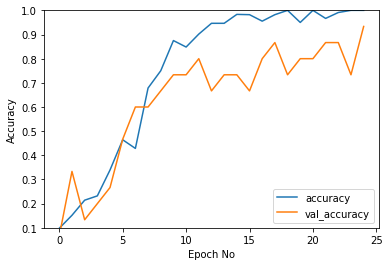

In [ ]:
plot_folder = "plot"
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch No')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

**Save model**

In [ ]:
MODEL_NAME = "keras_face_recognition.h5"
model_path = "./model"
if not os.path.exists(model_path):
    os.mkdir(model_path)

cnnmodel.save(os.path.join(model_path, MODEL_NAME))
class_names = training_generator.class_indices
class_names_file_reverse = MODEL_NAME[:-3] + "_class_names_reverse.npy"
class_names_file = MODEL_NAME[:-3] + "_class_names.npy"
np.save(os.path.join(model_path, class_names_file_reverse), class_names)
class_names_reversed = np.load(os.path.join(model_path, class_names_file_reverse), allow_pickle=True).item()
class_names = dict([(value, key) for key, value in class_names_reversed.items()])
np.save(os.path.join(model_path, class_names_file), class_names)

**Get random image**

In [ ]:
def get_sample_test_image():
    # Choose image sample
    expected_class = random.randint(1, 15)
    random_sample = random.randint(1, 3)
    # Build image path
    image_path = f"data/train/class_{expected_class}/class_{expected_class}_{random_sample}.png"
    # Read the file
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Return the results
    return img, expected_class

**process image**

In [ ]:
def preprocess_image(img):
    image = Image.fromarray(img)
    image = image.resize((160,160))
    face_array = np.asarray(image)
    # expands the dimensions
    face_array = face_array.reshape(160,160,1)
    face_array = face_array.astype('float32')
    scaled_image = np.expand_dims(face_array, axis=0)
    return scaled_image

**use model to predict image class**

In [ ]:
def prediction(image, debug=True): 
    # show the image
    plt.imshow(image)
    plt.show()

    # Process the sample
    input_sample = preprocess_image(img) 

    # Prediction
    results = cnnmodel.predict(input_sample)
    result = np.argmax(results, axis=1)
    index = result[0]

    # Calculate Confidence
    confidence = results[0][index] * 100
    classes = np.load(os.path.join("model", class_names_file), allow_pickle=True).item()
    # Get class name
    if type(classes) is dict:
        for k, v in classes.items():
            if k == index:
                class_name = v
    if debug:
        print(results)
        print("Detected class is {} with {:.2f}% confidence".format(class_name, round(confidence, 2)))
    
    # Return results
    return class_name, confidence

Expected class: 8


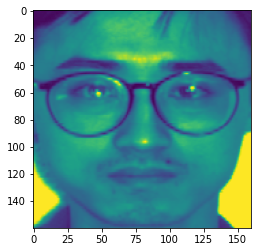

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Detected class is class_8 with 100.00% confidence


(('class_8', 100.0), 'expected:8')

In [ ]:
# Choose an image
img, expected_class = get_sample_test_image()

print(f"Expected class: {expected_class}")

prediction(img), f"expected:{expected_class}"

# Authentication system

In [ ]:
THRESHOLD = 90

ALLOWED_USERS = ["class_1", "class_2", "class_3", "class_4", "class_5"]

def authenticate(img, debug=False):
    class_name, confidence = prediction(img, debug)
    if (confidence < THRESHOLD):
        print("Face not recognised")
    elif (class_name in ALLOWED_USERS):
        print("Access Granted {}".format(class_name))
    else:
        print("You are not permitted {}".format(class_name))

expected class 14


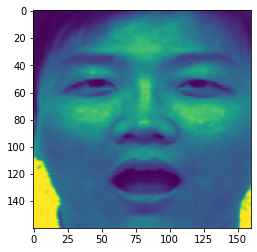

You are not permitted class_14


In [ ]:
img, expected_class = get_sample_test_image()
print(f"expected class {expected_class}")

authenticate(img)